# Explore AuxTel Prompt Processing Subtractions + APDB; BUT using custom reruns
## partially covered in DM-41323
Created by: Neven Caplar \
Started: 2023-10-25 \
Last modified: 2023-11-03 

Goals: Evaluate the quality of prompt processing on auxtel images, with custom reruns

    1. Find the variables in the night sky
        1. a) Create lightcurve from diaSources and evaluate the images
        1. b) Find known variable sources and evaluate how they are detected

In [1]:
# run before notebook the standard invokation: 'source /sdf/group/rubin/sw/loadLSST.bash'
# Note also:
# lsst.analysis.ap not yet in lsst distrib, just a data managment (dm) package
# so github clone from https://github.com/lsst/analysis_ap
# and add to your notebooks/.user_setups the following line
# setup -k -r <PATH_To_Directory>/analysis_ap

import numpy as np
import pandas as pd

# astropy imports
import astropy.units as u
from astropy.io import fits
from astropy.time import Time
from astropy.visualization.stretch import SinhStretch, LinearStretch, AsinhStretch
from astropy.visualization import ImageNormalize
from astropy.coordinates import Angle
from astropy.coordinates import SkyCoord

# warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


In [2]:
# AP LSST import
from lsst.analysis.ap import apdb, CutoutPath
from lsst.ap.association import UnpackApdbFlags

# all of the other lsst imports
import lsst.afw.display as afwDisplay
import lsst.daf.butler as dafButler
import lsst.geom as geom
from lsst.analysis.tools.actions.vector import ConvertUnits, FlagSelector, GoodDiaSourceSelector, LoadVector
from lsst.analysis.tools.atools import SkySourceHistPlot, SkySourceSkyPlot, NumDiaSourcesAllMetric, NumDiaSourcesMetric, NumDipolesMetric
from lsst.daf.butler import DataCoordinate
# Specific Dimension Packer 
from lsst.obs.lsst import RubinDimensionPacker
from lsst.utils import getPackageDir

# Visualization packages
import matplotlib.pyplot as plt
from IPython.display import Image, display
afwDisplay.setDefaultBackend('matplotlib')
%matplotlib inline

In [3]:
# just to check what it the status of analysis_ap import
!eups list analysis_ap
!git status

   LOCAL:/home/n/ncaplar/github/analysis_ap 	setup
On branch u/ncaplar/APDB_explore
Your branch is up to date with 'origin/u/ncaplar/APDB_explore'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   use_APDB_for_auxtel.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	Untitled1.ipynb
	Untitled2.ipynb
	Untitled3.ipynb
	Untitled4.ipynb
	bps_report.png
	untitled.txt
	use_APDB_for_auxtel_40791.ipynb
	use_APDB_for_auxtel_DM_41323.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [4]:
def find_products(diaSourceId_table, diaSourceId):
    """
    Helper function to find products from the original prompt processing

    Inputs
    ----------------

    Outputs
    ----------------
    
    
    Notes
    ----------------
    
    This substitutes the workflow such as
    
    ! butler query-datasets /sdf/group/rubin/repo/embargo \
    --collections "LATISS/prompt/output-2023-08-17/ApPipe/prompt-proto-service-00011" \
    --where "instrument='LATISS' and detector=0 and band='g' and visit >= 2023081700470 and visit <= 2023081700470" \
    deepDiff_differenceExp
    """
    
    source_row = diaSourceId_table[diaSourceId_table['diaSourceId'] == diaSourceId]
    if source_row.shape[0] != 1:
        # Add a custom comment here
        raise AssertionError("One and only one diaSource has to be in the diaSource table")

    # Start with the time in modified julian date (MJD)
    mjd = source_row['midpointMjdTai']
    # Convert to Julian Date
    jd = mjd + 2400000.5

    # Convert to astropy Time object
    t = Time(jd, format='jd')
    # subtract half a day to get when the run started
    start_t= t - 0.5 * u.day
    # Convert to datetime
    target_time = start_t.to_value('iso', subfmt='date')[0]
    print(target_time)
    for item in list(butler_query):
        if target_time in item:
            print("Found a match in butler!")
            # to remove " RUN" at the end of the string
            # quite clumsy and fragile
            collection_name = item[:-5]
    
    ap_collection = collection_name
    data_id = {"instrument": "LATISS", "detector": 0, "band": source_row['band'].values[0], "visit": int(source_row['visit'].values)}

    calexp = butler.get("calexp", dataId=data_id, collections=ap_collection)
    diff = butler.get("deepDiff_differenceExp", dataId=data_id, collections=ap_collection)
    template = butler.get("deepDiff_templateExp", dataId=data_id, collections=ap_collection)
    matched_template = butler.get("deepDiff_matchedExp", dataId=data_id, collections=ap_collection)

    # Includes detections and sky sources. Direct output from detect+measure after image subtraction.
    diaSrc = butler.get("deepDiff_diaSrc", dataId=data_id, collections=ap_collection)
    # The SDM/DPDD (Science Data Model/Data Products Definition Document) version of the diaSrc Table. No sky sources.  Flags are packed into uint64.
    diaSrcTable = butler.get("deepDiff_diaSrcTable", dataId=data_id, collections=ap_collection)
    
    return calexp, diff, template, matched_template, diaSrc, diaSrcTable

In [5]:
def show_cutout_triplet(template, science, diff, x, y, size=30, figsize=(16, 8), vmin_strech = 0.01, vmax_strech = 0.99):
    """
    Create and show a cutout of an template, science and difference image
    given a position
    """
    xy = geom.PointI(x, y)
    cutoutSize = geom.ExtentI(size, size)
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    
    assert template.getDimensions() == science.getDimensions() == diff.getDimensions()
    
    # clipping to the dimension of the image; prevents clipping outside of the image 
    bbox = bbox.clippedTo(template.getBBox())
    print(x, y, bbox)
    template_cutout = template.getCutout(bbox)
    science_cutout = science.getCutout(bbox)
    diff_cutout = diff.getCutout(bbox)

    # Use diff sigma for calexp, diff ranges.
    sigma = np.sqrt(np.median(diff.variance.array))

    fit, axes = plt.subplots(1, 3, figsize=figsize)
    plt.sca(axes[0])
    
    stretch =  AsinhStretch() 
    norm = ImageNormalize(stretch=stretch, vmin=np.quantile(template_cutout.image.array,0.01), vmax=np.quantile(template_cutout.image.array,vmax_strech))
    plt.imshow(template_cutout.image.array, cmap="gray", norm=norm, origin='lower')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title("Template")
    plt.sca(axes[1])
    plt.imshow(science_cutout.image.array, cmap="gray", norm=norm, origin='lower')
    plt.title("Science")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.sca(axes[2])
    plt.imshow(diff_cutout.image.array, cmap="gray", vmin=-3*sigma, vmax=+3*sigma, origin='lower')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title("Diff")

# Set up butler

In [6]:
repo = "/sdf/group/rubin/repo/embargo/"
butler = dafButler.Butler(repo)

# Which collection are avaliable from prompt processing
# The information from this query can be also found here:
# https://confluence.lsstcorp.org/display/DM/Prompt+Processing+with+AuxTel+Imaging+Survey+Data+2023
butler_query = ! butler query-collections /sdf/group/rubin/repo/embargo "LATISS/prompt/*-2023-*/ApPipe/*"
butler_query

['                               Name                               Type',
 '----------------------------------------------------------------- ----',
 'LATISS/prompt/output-2023-05-24/ApPipe/prompt-proto-service-00026 RUN ',
 'LATISS/prompt/output-2023-05-25/ApPipe/prompt-proto-service-00027 RUN ',
 'LATISS/prompt/output-2023-07-20/ApPipe/prompt-proto-service-00007 RUN ',
 'LATISS/prompt/output-2023-08-15/ApPipe/prompt-proto-service-00010 RUN ',
 'LATISS/prompt/output-2023-08-16/ApPipe/prompt-proto-service-00011 RUN ',
 'LATISS/prompt/output-2023-08-17/ApPipe/prompt-proto-service-00011 RUN ',
 'LATISS/prompt/output-2023-08-29/ApPipe/prompt-proto-service-00013 RUN ']

In [7]:
# Which collection are avaliable from custom reruns
# The command that created this collection is found in the ticket
# Let us concentrate on November 01 run with weekly 43 
# earlier runs were testing runs or did not complete fully
# Note that these runs do not include results of DRP Latiss sprint in October 2023
butler_query_custom =! butler query-collections /sdf/group/rubin/repo/embargo "u/ncaplar/DM-41323/20231101*"
butler_query_custom

['                Name                Type',
 '----------------------------------- ----',
 'u/ncaplar/DM-41323/20231101T192110Z RUN ']

In [8]:
schema = 'pp_apdb'
instrument = 'LATISS'

apdbQuery = apdb.ApdbPostgresQuery(schema, url="rubin@usdf-prompt-processing.slac.stanford.edu/lsst-devl",\
                                   butler=butler, instrument=instrument)

# This is previous command that was writting to sqlite database
# Sqlite was failling because it can not take too many connections at once
# apdbQuery_custom = apdb.ApdbSqliteQuery(filename = '/home/n/ncaplar/rubin-user/DM-41323/apdb.db',\
#                                   butler=butler, instrument=instrument)

# we are now using development postgres database
schema = 'ncaplar_dm_41323'
apdbQuery_custom = apdb.ApdbPostgresQuery(schema, url="rubin@usdf-prompt-processing-dev.slac.stanford.edu/lsst-devl",\
                                   butler=butler, instrument=instrument)

In [9]:
sources = apdbQuery.load_sources(exclude_flagged=True)
# we now make a reduced dataframe, with only columns that are of interest to us
sources_cortado = sources[['diaSourceId','diaObjectId','ra','dec','x','y','midpointMjdTai','psfFlux','psfFluxErr','scienceFlux','scienceFluxErr','snr', 'band','flags','visit']]

# need to specify limit explicity
# implicitly it is 100000 and we are above that limit
sources_custom = apdbQuery_custom.load_sources(exclude_flagged = True, limit=200000)
sources_custom_cortado = sources_custom[['diaSourceId','diaObjectId','ra','dec','x','y','midpointMjdTai','psfFlux','psfFluxErr','scienceFlux','scienceFluxErr','snr', 'band','flags','visit']]

"""
sources_cortado.loc[:, 'mag'] = u.nJy.to(u.ABmag, sources_cortado.loc[:,'scienceFlux'])
upper_mag = u.nJy.to(u.ABmag, sources_cortado.loc[:,'scienceFlux']+sources_cortado.loc[:,'scienceFluxErr'])
lower_mag = u.nJy.to(u.ABmag, sources_cortado.loc[:,'scienceFlux']-sources_cortado.loc[:,'scienceFluxErr'])
magErr = -(upper_mag-lower_mag)/2
sources_cortado.loc[:,'magErr'] = magErr
"""



"\nsources_cortado.loc[:, 'mag'] = u.nJy.to(u.ABmag, sources_cortado.loc[:,'scienceFlux'])\nupper_mag = u.nJy.to(u.ABmag, sources_cortado.loc[:,'scienceFlux']+sources_cortado.loc[:,'scienceFluxErr'])\nlower_mag = u.nJy.to(u.ABmag, sources_cortado.loc[:,'scienceFlux']-sources_cortado.loc[:,'scienceFluxErr'])\nmagErr = -(upper_mag-lower_mag)/2\nsources_cortado.loc[:,'magErr'] = magErr\n"

In [10]:
num_unique_visits = len(np.unique(sources_cortado['visit']))
num_unique_visits_custom = len(np.unique(sources_custom_cortado['visit']))
num_sources = len(sources)
num_sources_custom = len(sources_custom)
print(f"Number of unique visits represented in original processing is {num_unique_visits}")
print(f"Number of unique visits represented in rerun processing is {num_unique_visits_custom}")
print(f"Number of unique diaSources represented in original processing is {num_sources}")
print(f"Number of unique diaSources represented in rerun processing is {num_sources_custom}")

Number of unique visits represented in original processing is 363
Number of unique visits represented in rerun processing is 1624
Number of unique diaSources represented in original processing is 68094
Number of unique diaSources represented in rerun processing is 132416


In [11]:
# visits which are avaliable in both versions of processing
visit_intersect = np.intersect1d(np.unique(sources['visit']), np.unique(sources_custom['visit']))
visit_intersect[:5]
num_visit_intersect = len(visit_intersect)
print(f"Number of  visits represented in both versions of processing is {num_visit_intersect}")

Number of  visits represented in both versions of processing is 352


# Let us look at the single visit, single cutout

## Original processing 

In [12]:
(sources_cortado[sources_cortado['visit'] == visit_intersect[30]]['scienceFlux']).max()

34561459.16024893

In [13]:
sources_cortado.loc[(sources_cortado['visit'] == visit_intersect[30]) & (sources_cortado['scienceFlux'] > 13650758.101768)]

,diaSourceId,diaObjectId,ra,dec,x,y,midpointMjdTai,psfFlux,psfFluxErr,scienceFlux,scienceFluxErr,snr,band,flags,visit
2239,174092474959004778,174092472811521086,270.123767,-24.967331,2406.166992,1379.043213,60146.05735,-2.972350e+06,37773.956444,1.748644e+07,47364.825494,76.867081,r,0,2023072000188
2254,174092474959004818,174092472811521124,270.114014,-24.977195,2743.516757,1745.896438,60146.05735,-2.306520e+05,43429.561854,2.808435e+07,55376.614349,8.540875,r,8388608,2023072000188
2268,174092474959004855,174092472811521154,270.096688,-24.986372,3338.672918,2083.687761,60146.05735,4.026090e+05,42529.501114,2.578208e+07,54014.662313,22.374908,r,8388608,2023072000188
2271,174092474959004861,174092474959004861,270.109553,-24.987599,2900.600387,2135.349383,60146.05735,8.934726e+05,47335.004851,3.060159e+07,60441.907651,31.857660,r,8388608,2023072000188
2289,174092474959004913,174092472811521198,270.106529,-25.002954,3011.071922,2711.649433,60146.05735,1.083882e+06,49765.387576,3.456146e+07,64462.877722,30.478863,r,8388608,2023072000188
2299,174092474959004977,174092447041716761,270.153830,-25.018625,1406.232796,3321.687350,60146.05735,-8.389525e+03,33664.519764,1.563382e+07,42919.444866,14.913064,r,8388608,2023072000188
2309,174092474959005004,174092443820491250,270.185934,-25.025098,315.144505,3579.407162,60146.05735,3.357640e+05,33439.835443,1.425985e+07,41997.393018,14.914777,r,0,2023072000188
2313,174092474959005023,174092474959005023,270.115247,-25.030818,2727.274659,3763.557746,60146.05735,2.405094e+04,35623.489775,1.998242e+07,46289.945487,11.402606,r,8388608,2023072000188
2317,174092474959005032,174092443820491270,270.190835,-25.031965,151.536075,3839.918695,60146.05735,6.738779e+04,41518.019089,2.238223e+07,52412.490439,13.429998,r,8388608,2023072000188
2318,174092474959005042,174092443820491276,270.194554,-25.034127,25.850771,3922.943115,60146.05735,1.833995e+06,34080.685438,1.811707e+07,42178.120522,51.213882,r,0,2023072000188


In [14]:
sources_cortado.loc[54724]

diaSourceId       175500123646722922
diaObjectId       174092479253972518
ra                        270.215216
dec                       -24.988478
x                        3799.822398
y                        1754.949328
midpointMjdTai          60186.174652
psfFlux               4176277.419714
psfFluxErr              57314.382522
scienceFlux           92831498.59074
scienceFluxErr          65908.141672
snr                       101.353386
band                               i
flags                              0
visit                  2023082900443
Name: 54724, dtype: object

In [15]:
# let us try to get image for the diaSourceId 175077989564809969
diaSourceId_v = 175500123646722922
diaObject_v = 174092479253972518

# this function should take care of all of that
# butler query needs to be run before because I use butler_query in the function... TBD: fix that
calexp, diff, template, matched_template, diaSrc, diaSrcTable = find_products(sources, diaSourceId_v)

single_diaSource = sources_cortado[sources_cortado['diaSourceId'] == diaSourceId_v]
visit_single_diaSource = single_diaSource['visit'].values[0]

sources_single_visit = sources_cortado[sources_cortado['visit'] == visit_single_diaSource]

2023-08-29
Found a match in butler!


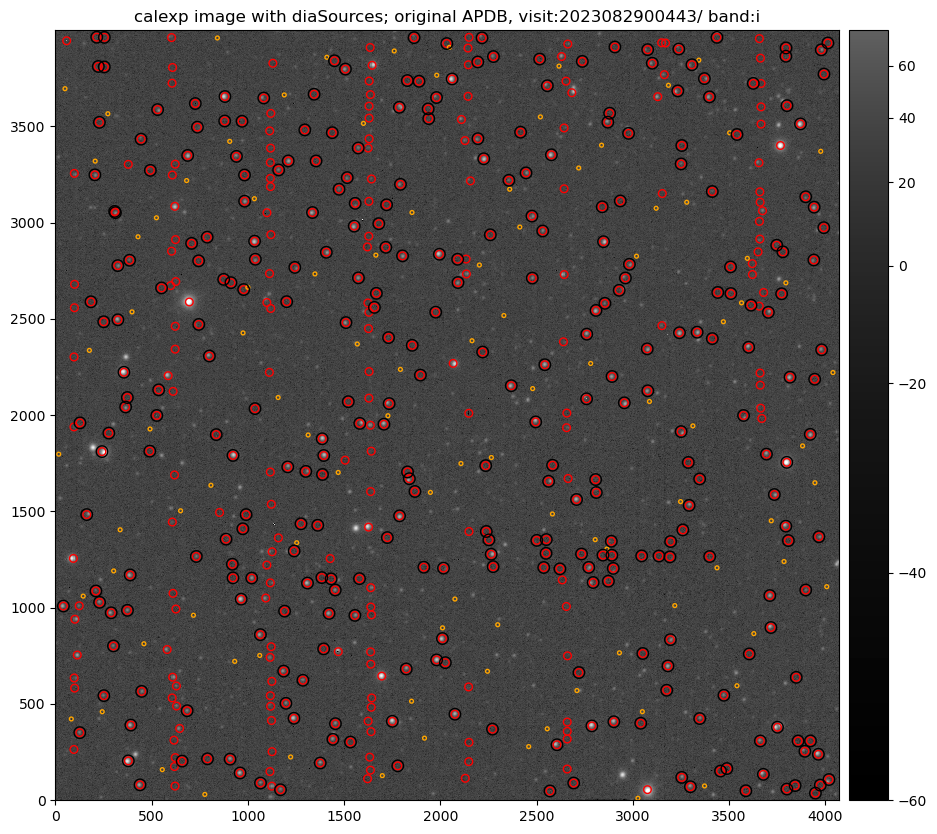

In [16]:
fig = plt.figure(figsize=(16, 10))
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(calexp.image)
# display.mtv(diff.image)
with display.Buffering():
    for s in diaSrc:
        if s['sky_source']:
            display.dot("o", s.getX(), s.getY(), size=10, ctype="orange")
        else:
            display.dot("o", s.getX(), s.getY(), size=20, ctype="red")
    for index, row in sources_single_visit[['x','y']].iterrows():
        display.dot("o", row['x'], row['y'], size=30, ctype="black")
        
plt.title('calexp image with diaSources; original APDB, visit:' + str(single_diaSource['visit'].values[0]) + '/ band:'+str(single_diaSource['band'].values[0]))
plt.show()


In [17]:
single_diaSource = sources_cortado[sources_cortado['diaSourceId'] == diaSourceId_v]

54724    3799.822398
Name: x, dtype: float64 54724    1754.949328
Name: y, dtype: float64 (minimum=(3734, 1689), maximum=(3863, 1818))


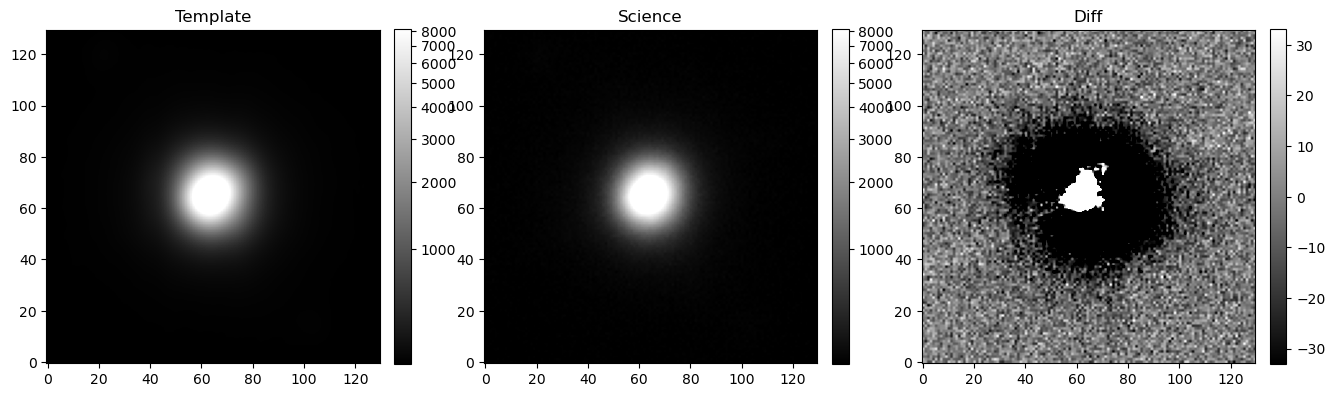

In [18]:
stamp_size = 30 # pixels.  Size of baseline alert stamp
stamp_size = 130 # pixels.  Bigger stamp to see more detail
x = single_diaSource['x']
y = single_diaSource['y']

show_cutout_triplet(matched_template, calexp, diff, x, y, size=stamp_size)

## weekly 43 rerun 

In [19]:
ap_collection = 'u/ncaplar/DM-41323/20231101T192110Z'
data_id = {"instrument": "LATISS", "detector": 0, "band": single_diaSource['band'].values[0], "visit": int(single_diaSource['visit'].values)}

In [20]:
calexp_custom = butler.get("calexp", dataId=data_id, collections=ap_collection)
diff_custom = butler.get("deepDiff_differenceExp", dataId=data_id, collections=ap_collection)
template_custom = butler.get("deepDiff_templateExp", dataId=data_id, collections=ap_collection)
matched_template_custom = butler.get("deepDiff_matchedExp", dataId=data_id, collections=ap_collection)
# Includes detections and sky sources. Direct output from detect+measure after image subtraction.
diaSrc_custom = butler.get("deepDiff_diaSrc", dataId=data_id, collections=ap_collection)
# The SDM/DPDD (Science Data Model/Data Products Definition Document) version of the diaSrc Table. No sky sources.  Flags are packed into uint64.
diaSrcTable_custom = butler.get("deepDiff_diaSrcTable", dataId=data_id, collections=ap_collection)


In [21]:
# get the sources from the same visit
sources_single_visit_custom = sources_custom_cortado[sources_custom_cortado['visit'] == visit_single_diaSource]

In [22]:
# find the same source here
# have to a spatical search
sources_single_visit_custom[(sources_single_visit_custom['x'] < (x.values[0] + 10)) & \
                            (sources_single_visit_custom['x'] > (x.values[0] - 10)) & \
                            (sources_single_visit_custom['y'] > (y.values[0] - 10)) & \
                            (sources_single_visit_custom['y'] < (y.values[0] + 10))]

,diaSourceId,diaObjectId,ra,dec,x,y,midpointMjdTai,psfFlux,psfFluxErr,scienceFlux,scienceFluxErr,snr,band,flags,visit
125303,175500123646722638,175077985269842178,270.215152,-24.988431,3797.690792,1756.763275,60186.174652,1.075939e+06,56970.33947,9.456012e+07,68355.2793,31.747335,i,0,2023082900443


In [23]:
diaObjectId_custom_v = 175077985269842178
single_diaSource_custom = sources_custom_cortado[sources_custom_cortado['diaSourceId'] == 175500123646722638]
sources_single_visit_custom = sources_custom_cortado[sources_custom_cortado['visit'] == 2023082900443]

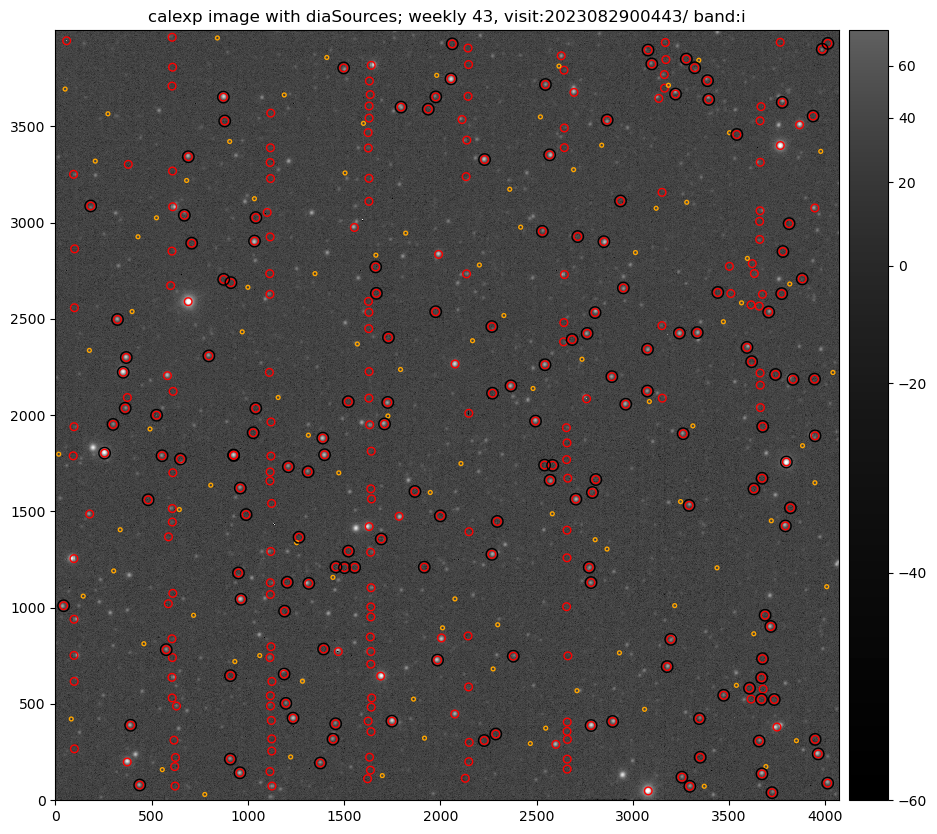

In [24]:
fig = plt.figure(figsize=(16, 10))
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(calexp.image)
# display.mtv(diff.image)
with display.Buffering():
    for s in diaSrc_custom:
        if s['sky_source']:
            display.dot("o", s.getX(), s.getY(), size=10, ctype="orange")
        else:
            display.dot("o", s.getX(), s.getY(), size=20, ctype="red")
    for index, row in sources_single_visit_custom[['x','y']].iterrows():
        display.dot("o", row['x'], row['y'], size=30, ctype="black")
        
plt.title('calexp image with diaSources; weekly 43, visit:' + str(single_diaSource_custom['visit'].values[0]) + '/ band:'+str(single_diaSource_custom['band'].values[0]))
plt.show()

54724    3799.822398
Name: x, dtype: float64 54724    1754.949328
Name: y, dtype: float64 (minimum=(3734, 1689), maximum=(3863, 1818))


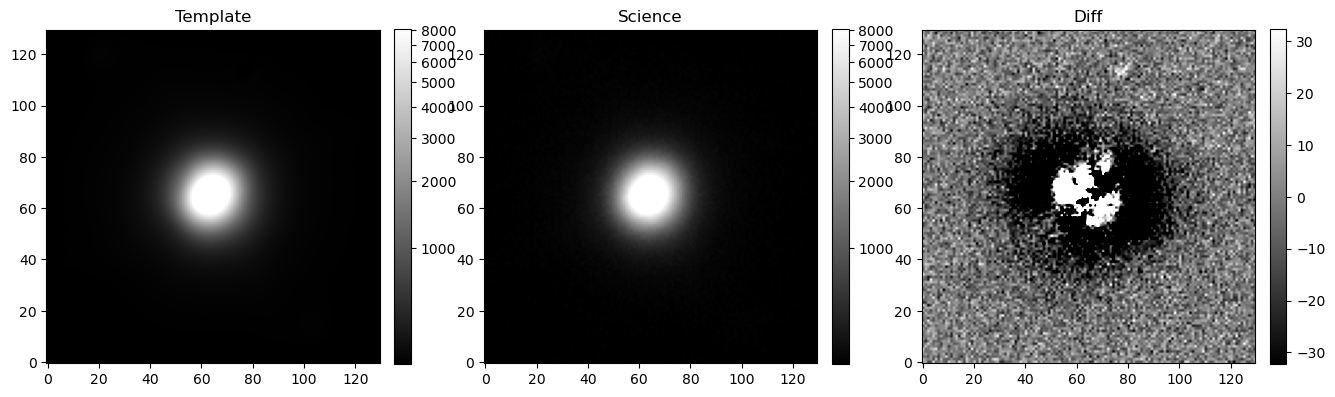

In [25]:
stamp_size = 30 # pixels.  Size of baseline alert stamp
stamp_size = 130 # pixels.  Bigger stamp to see more detail
x = single_diaSource['x']
y = single_diaSource['y']

show_cutout_triplet(matched_template_custom, calexp_custom, diff_custom, x, y, size=stamp_size)

# Lightcurve

In [26]:
 # Select a random lightcurve
lc = sources_cortado[sources_cortado['diaObjectId'] ==  diaObject_v]
lc_custom = sources_custom_cortado[sources_custom_cortado['diaObjectId'] ==  diaObjectId_custom_v]

In [27]:
lc

,diaSourceId,diaObjectId,ra,dec,x,y,midpointMjdTai,psfFlux,psfFluxErr,scienceFlux,scienceFluxErr,snr,band,flags,visit
2788,174092479253972518,174092479253972518,270.215367,-24.988466,964.967804,2197.046361,60146.059522,2.136296e+06,79425.218678,8.210491e+07,105469.299496,49.928841,i,0,2023072000192
3011,174092481401455785,174092479253972518,270.215228,-24.988419,972.164827,2195.604070,60146.060549,3.115341e+04,43630.720027,2.868618e+07,55564.042635,49.246235,r,8388608,2023072000194
3987,174092495360099422,174092479253972518,270.215158,-24.988372,1511.719246,2173.742667,60146.069105,-2.291215e+05,43796.741896,2.348746e+07,56706.234256,35.437252,r,0,2023072000207
4174,174092497507583684,174092479253972518,270.215375,-24.988394,1510.267517,2178.754126,60146.070133,1.284606e+06,55807.973499,5.403340e+07,71053.926639,62.577545,i,8388608,2023072000209
4847,174092507171259654,174092479253972518,270.215163,-24.988371,3200.606927,2159.671366,60146.074867,-4.657701e+05,39877.790412,2.513457e+07,51864.165959,25.061504,r,0,2023072000218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61992,175500161227686353,174092479253972518,270.215197,-24.988552,1039.105470,1771.582688,60186.193585,5.996771e+04,16858.203783,2.987933e+06,14097.042893,28.201307,g,8388608,2023082900478
64588,175500174112588199,174092479253972518,270.215188,-24.988494,3253.996865,631.053120,60186.200069,1.399526e+05,16148.423305,2.612646e+06,13100.822352,30.336966,g,0,2023082900490
65633,175500179481297446,174092479253972518,270.215183,-24.988517,1022.745216,659.116173,60186.202787,1.450009e+06,35767.901819,2.490888e+07,35229.211036,59.872673,r,0,2023082900495
67484,175500188071232193,174092479253972518,270.215264,-24.988392,464.968102,670.433835,60186.206997,2.653610e+06,53149.830554,7.080799e+07,49527.659738,71.872932,i,0,2023082900503


In [28]:
lc_custom

,diaSourceId,diaObjectId,ra,dec,x,y,midpointMjdTai,psfFlux,psfFluxErr,scienceFlux,scienceFluxErr,snr,band,flags,visit
25306,173564885471330899,175077985269842178,270.215065,-24.988331,999.769792,3370.473731,60131.184320,-4.012226e+05,53387.995930,7.142696e+07,88210.263701,6.234892,i,8388608,2023070500352
25533,173564887618814367,175077985269842178,270.215142,-24.988650,444.144227,3364.163639,60131.185393,7.200452e+04,11477.576260,2.383862e+06,9854.479814,10.215935,g,0,2023070500354
25605,173564888692556177,175077985269842178,270.215153,-24.988526,443.152732,3368.934792,60131.185906,4.301811e+05,33437.277377,2.332220e+07,31659.453671,19.523771,r,0,2023070500355
27324,173564931642229095,175077985269842178,270.215215,-24.988656,3543.011560,2396.319223,60131.217238,-9.464047e+04,59099.255891,7.031963e+07,82143.326658,11.780455,i,0,2023070500395
27414,173564932715970970,175077985269842178,270.215256,-24.988509,2984.727288,2409.833473,60131.217796,-2.406853e+06,70062.081902,7.599354e+07,98659.555531,16.033260,i,0,2023070500396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129192,175500160153944400,175077985269842178,270.215074,-24.988613,1027.753889,1771.020846,60186.193070,-6.623130e+03,32076.310730,2.178344e+07,31798.075788,24.009809,r,8388608,2023082900477
130382,175500173038846284,175077985269842178,270.215179,-24.988500,3245.164941,634.498550,60186.199554,-2.046181e+05,34549.529438,2.316366e+07,35012.863622,5.000085,r,0,2023082900489
131169,175500180555039161,175077985269842178,270.215174,-24.988508,1033.189347,654.752049,60186.203301,1.410379e+05,15319.336633,2.760715e+06,13158.694525,29.414949,g,0,2023082900496
131326,175500181628781050,175077985269842178,270.215148,-24.988571,1018.237534,658.448085,60186.203814,-1.120801e+06,57884.656537,8.762695e+07,76208.601551,56.453529,i,8388608,2023082900497


In [29]:
def scFlux_to_mag(lc):
    mag = u.nJy.to(u.ABmag, lc.loc[:,'scienceFlux'])
    upper_mag = u.nJy.to(u.ABmag, lc.loc[:,'scienceFlux']+lc.loc[:,'scienceFluxErr'])
    lower_mag = u.nJy.to(u.ABmag, lc.loc[:,'scienceFlux']-lc.loc[:,'scienceFluxErr'])
    magErr = -(upper_mag-lower_mag)/2
    return mag, magErr


Text(0, 0.5, 'science flux [nJy] or [mag]')

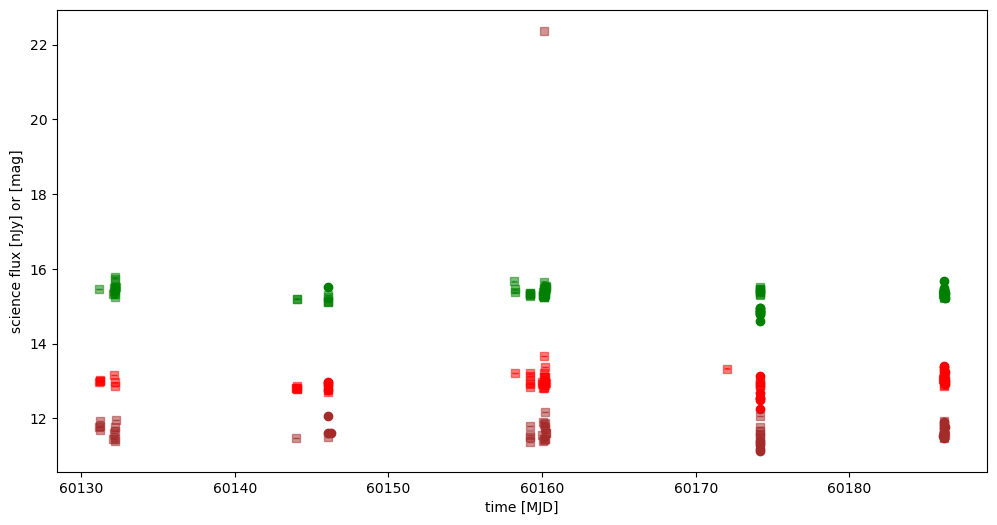

In [30]:
plt.figure(figsize=(12,6))
plt_color_band = ['green', 'red', 'brown']
for i,band in enumerate(['g', 'r', 'i']):
    lc_sband = lc[lc['band'] == band]
    lc_custom_sband = lc_custom[lc_custom['band'] == band]


    mag, magErr = scFlux_to_mag(lc_sband)
    mag_custom, magErr_custom = scFlux_to_mag(lc_custom_sband)    
    
    """
    plt.errorbar(lc_sband['midpointMjdTai'], lc_sband['scienceFlux'], yerr=lc_sband['scienceFluxErr'],
                 marker='o', capsize=2, ls='', color = plt_color_band[i])
    plt.errorbar(lc_custom_sband['midpointMjdTai'], lc_custom_sband['scienceFlux'], yerr=lc_custom_sband['scienceFluxErr'],
                 marker='s', capsize=2, ls='', color = plt_color_band[i])
    """

    plt.errorbar(lc_sband['midpointMjdTai'], mag, yerr=magErr,
                 marker='o', capsize=2, ls='', color = plt_color_band[i])
    plt.errorbar(lc_custom_sband['midpointMjdTai'], mag_custom, yerr=magErr_custom,
                 marker='s', capsize=2, ls='', color = plt_color_band[i], alpha = 0.5)

plt.xlabel('time [MJD]')
plt.ylabel('science flux [nJy] or [mag]')


In [31]:
# joined with forced list
# take 5 to 10 minutes
# 6GB of memory?

#  4 mil sources
forced_sources = apdbQuery.load_forced_sources(limit=10000000)
# 10+ million sources
forced_sources_custom = apdbQuery_custom.load_forced_sources(limit=10000000)

In [32]:
len(forced_sources_custom)

10000000

In [33]:
len(forced_sources)

4102994

In [34]:
forced_sources_custom

,diaForcedSourceId,diaObjectId,ccdVisitId,psfFlux,psfFluxErr,x,y,flags,midpointMjdTai,scienceFlux,scienceFluxErr,band,time_processed,time_withdrawn,visit,detector,instrument
0,171629648369680385,171629649443422389,40919696896,-12346.907579,4857.758209,3949.094202,3813.708857,0,60076.047874,-9594.939356,5745.158084,r,2023-11-01 19:57:43.821594,None,2023051100262,0,LATISS
1,171629648369680390,171629649443422408,40919696896,-6227.260348,5244.582857,2226.691826,3905.150907,0,60076.047874,-4215.285232,6269.587845,r,2023-11-01 19:57:43.821594,None,2023051100262,0,LATISS
2,171629648369680391,171629649443422409,40919696896,-8285.984763,5227.997655,2644.117581,3609.846079,0,60076.047874,-8415.691773,6214.983521,r,2023-11-01 19:57:43.821594,None,2023051100262,0,LATISS
3,171629648369680392,171629649443422413,40919696896,-2807.204864,5270.235073,2074.014143,3608.546989,0,60076.047874,-1716.449807,6284.337804,r,2023-11-01 19:57:43.821594,None,2023051100262,0,LATISS
4,171629648369680393,171629649443422423,40919696896,-2335.380308,5312.085503,2220.713247,2783.474296,0,60076.047874,1774.232453,6281.452644,r,2023-11-01 19:57:43.821594,None,2023051100262,0,LATISS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999995,174585377217068067,175007182733967815,41624397568,4328.210336,4008.984832,1081.823690,81.282314,0,60160.106549,5714.143748,4571.442886,g,2023-11-01 20:04:03.365940,None,2023080300487,0,LATISS
9999996,174585377217068068,175007182733967818,41624397568,-8060.685369,3968.876754,1080.526247,151.372932,0,60160.106549,-6275.266075,4540.864167,g,2023-11-01 20:04:03.365940,None,2023080300487,0,LATISS
9999997,174585377217068069,175007182733967819,41624397568,2471.074864,4435.051846,3116.975863,233.293929,0,60160.106549,7146.744971,5071.279639,g,2023-11-01 20:04:03.365940,None,2023080300487,0,LATISS
9999998,174585377217068073,175007182733967827,41624397568,2301.767208,4112.048719,2104.842855,354.426740,0,60160.106549,1201.913245,4716.550322,g,2023-11-01 20:04:03.365940,None,2023080300487,0,LATISS


In [35]:
diaObjectId_custom_v

175077985269842178

In [36]:
test = apdbQuery.load_forced_sources_for_object(dia_object_id = 174092479253972518)
test

,diaForcedSourceId,diaObjectId,ccdVisitId,psfFlux,psfFluxErr,x,y,flags,midpointMjdTai,scienceFlux,scienceFluxErr,band,time_processed,time_withdrawn,visit,detector,instrument
0,174092479253973594,174092479253972518,41506881536,2.326045e+06,86479.873696,964.967804,2197.046361,0,60146.059522,8.210491e+07,105469.299496,i,2023-07-21 01:28:36.012027,None,2023072000192,0,LATISS
1,174092480327715628,174092479253972518,41506881792,1.801487e+05,15556.130150,970.301388,2197.787660,0,60146.060035,2.275016e+06,17875.878683,g,2023-07-21 01:29:37.125322,None,2023072000193,0,LATISS
2,174092481401457635,174092479253972518,41506882048,5.371377e+05,43937.009386,969.815805,2196.530889,0,60146.060549,2.580783e+07,51701.882679,r,2023-07-21 01:30:01.494758,None,2023072000194,0,LATISS
3,174092495360101440,174092479253972518,41506885376,4.299921e+05,51316.447542,1508.558072,2175.549640,0,60146.069105,2.643951e+07,61545.788442,r,2023-07-21 01:42:12.119428,None,2023072000207,0,LATISS
4,174092496433843470,174092479253972518,41506885632,1.836717e+05,18776.122230,1515.333431,2178.059056,0,60146.069619,3.177817e+06,22116.932299,g,2023-07-21 01:43:08.552522,None,2023072000208,0,LATISS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,175500181628782119,174092479253972518,41842503936,1.686370e+06,44833.909816,1021.969361,659.712339,0,60186.203814,8.148872e+07,59078.140253,i,2023-08-30 04:57:21.480677,None,2023082900497,0,LATISS
205,175500185923770638,174092479253972518,41842504960,6.314601e+05,26321.532653,468.630495,661.724851,0,60186.205968,2.308972e+07,30719.545751,r,2023-08-30 05:00:22.514142,None,2023082900501,0,LATISS
206,175500186997513275,174092479253972518,41842505216,9.630561e+03,11282.290499,480.768155,660.150630,0,60186.206482,2.533116e+06,12405.196363,g,2023-08-30 05:00:48.007647,None,2023082900502,0,LATISS
207,175500188071254592,174092479253972518,41842505472,1.808317e+06,44390.884630,464.664641,665.055559,0,60186.206997,8.097053e+07,54916.256098,i,2023-08-30 05:02:00.794275,None,2023082900503,0,LATISS


In [37]:
# alternative way to query postgres directly 
_tables = apdbQuery_custom._tables

table = _tables["DiaForcedSource"]
query = table.select().where(table.columns["diaObjectId"] == 174092479253972518)
with apdbQuery_custom.connection as connection:
    lc_custom_forced = pd.read_sql_query(query, connection)



In [38]:
lc_custom_forced

,diaForcedSourceId,diaObjectId,ccdVisitId,psfFlux,psfFluxErr,x,y,flags,midpointMjdTai,scienceFlux,scienceFluxErr,band,time_processed,time_withdrawn


In [39]:
plt.figure(figsize=(12,6))
plt_color_band = ['green', 'red', 'brown']
for i,band in enumerate(['g', 'r', 'i']):
    lc_custom_f_sband = lc_custom_forced[lc_custom_forced['band'] == band]
    lc_custom_sband = lc_custom[lc_custom['band'] == band]


    mag, magErr = scFlux_to_mag(lc_custom_f_sband)
    mag_custom, magErr_custom = scFlux_to_mag(lc_custom_sband)    
    
    """
    plt.errorbar(lc_sband['midpointMjdTai'], lc_sband['scienceFlux'], yerr=lc_sband['scienceFluxErr'],
                 marker='o', capsize=2, ls='', color = plt_color_band[i])
    plt.errorbar(lc_custom_sband['midpointMjdTai'], lc_custom_sband['scienceFlux'], yerr=lc_custom_sband['scienceFluxErr'],
                 marker='s', capsize=2, ls='', color = plt_color_band[i])
    """

    plt.errorbar(lc_custom_f_sband['midpointMjdTai'], mag, yerr=magErr,
                 marker='o', capsize=2, ls='', color = plt_color_band[i])
    plt.errorbar(lc_custom_sband['midpointMjdTai'], mag_custom, yerr=magErr_custom,
                 marker='s', capsize=2, ls='', color = plt_color_band[i], alpha = 0.5)

plt.xlabel('time [MJD]')
plt.ylabel('science flux [nJy] or [mag]')

plt.ylim(12,16.5)

ValueError: Value not scalar compatible or convertible to an int, float, or complex array

<Figure size 1200x600 with 0 Axes>

In [ ]:
band = 'r'
lc_custom_f_sband = lc_custom_forced[lc_custom_forced['band'] == band]
lc_custom_sband = lc_custom[lc_custom['band'] == band]


mag_f, magErr_f = scFlux_to_mag(lc_custom_f_sband)
mag_custom, magErr_custom = scFlux_to_mag(lc_custom_sband)    

In [ ]:
np.intersect1d(lc_custom_f_sband['midpointMjdTai'], lc_custom_sband['midpointMjdTai'])

In [ ]:
int_index = np.in1d(lc_custom_f_sband['midpointMjdTai'], lc_custom_sband['midpointMjdTai'])

In [ ]:
plt.figure(figsize=(12,6))


plt.errorbar(lc_custom_sband['midpointMjdTai'], mag_custom, yerr=magErr_custom,
             marker='o', capsize=2, ls='', color = 'orange', label = 'diaSources')

plt.errorbar(lc_custom_f_sband['midpointMjdTai'], mag_f, yerr=magErr_f,
             marker='s', capsize=2, ls='', color = 'red', label = 'diaForcedSources')
#plt.errorbar(lc_custom_sband['midpointMjdTai'], mag_custom, yerr=magErr_custom,
#             marker='s', capsize=2, ls='', color = plt_color_band[i], alpha = 0.5)

plt.xlabel('visit')
plt.ylabel('science flux [nJy] or [mag]')
plt.legend()

plt.ylim(12.5, 13.75)

In [ ]:
plt.figure(figsize=(12,6))


plt.errorbar(np.arange(len(mag_f))[int_index], mag_custom, yerr=magErr_custom,
             marker='o', capsize=2, ls='', color = 'orange', label = 'diaSources')

plt.errorbar(np.arange(len(mag_f)), mag_f, yerr=magErr_f,
             marker='s', capsize=2, ls='', color = 'red', label = 'diaForcedSources')
#plt.errorbar(lc_custom_sband['midpointMjdTai'], mag_custom, yerr=magErr_custom,
#             marker='s', capsize=2, ls='', color = plt_color_band[i], alpha = 0.5)

plt.xlabel('visit')
plt.ylabel('science flux [nJy] or [mag]')
plt.legend()

plt.ylim(12.5, 13.75)

In [ ]:
# let us look at the exposure where these two differ a lot
# let us find gaia variables
# let us find variables